## PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

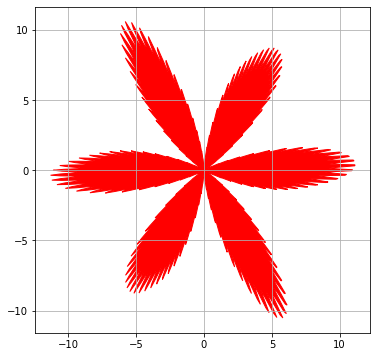

In [2]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + torch.cos(6*theta)) * (1 + 0.01*torch.cos(24*theta)) * \
(0.5 + 0.05*torch.cos(200*theta)) * (10 + torch.sin(10*theta))### YOUR CODE HERE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)### YOUR CODE HERE
y = rho * torch.sin(theta) ### YOUR CODE HERE


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [3]:
from torch import nn
from torch.nn import functional as F

In [4]:
# !wget https://github.com/yandexdataschool/Practical_RL/blob/master/week04_%5Brecap%5D_deep_learning/notmnist.py

In [4]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [5]:
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(14043, 1, 28, 28)


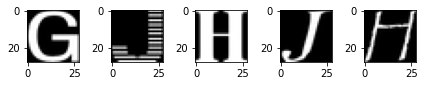

In [6]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i][0], cmap = "gray")
    plt.tight_layout()
    
plt.show()

In [7]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, 
                                                      letters=letters, 
                                                      test_size=0.2)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [8]:
full_dataset = DatasetMNIST('./notMNIST_small', transform=None)

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [9]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [10]:
a = torchvision.transforms.ToTensor()
a(img).shape

torch.Size([1, 28, 28])

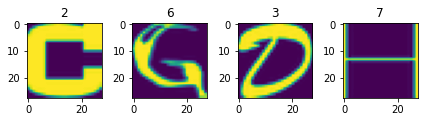

In [11]:
inds = np.random.randint(len(full_dataset), size=4)

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))
    plt.tight_layout()

#### To the DataLoader

In [12]:
train_loader = DataLoader(full_dataset, batch_size=128, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [13]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [14]:
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([128, 28, 28, 1])
labels shape on batch size = torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


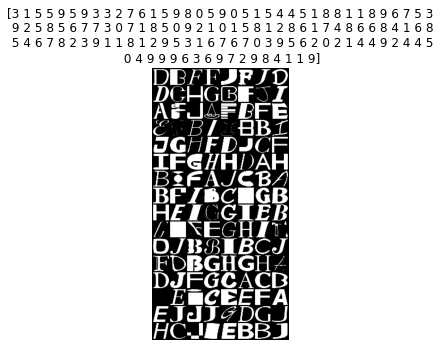

In [25]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))
plt.figure(figsize = (10, 5))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [15]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [16]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [17]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=128, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([128, 1, 28, 28])
labels shape on batch size = torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


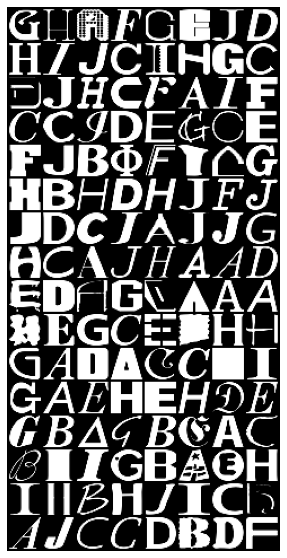

In [26]:
grid = torchvision.utils.make_grid(images)
plt.figure(figsize = (10, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off');
# plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [27]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [28]:
a = Flatten()

In [29]:
a(img).shape

torch.Size([784])

In [30]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [84]:
import time

from IPython.display import clear_output

In [85]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [86]:
def subset_ind(dataset, ratio: float):
#     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [151]:
dataset = DatasetMNIST(
    './notMNIST_small',
    #'ABCD',
    transform=new_transform
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 2995, labels: [0 1 2 3 4 5 6 7 8 9]


In [152]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2396
validation size: 599


In [153]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [154]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [127]:
loss_func = nn.CrossEntropyLoss()

In [155]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [156]:
# how works model:
example_out = model(images.to(device))
print(example_out.shape)

torch.Size([32, 10])


In [157]:
example_loss = loss_func(example_out, labels.type(torch.LongTensor).to(device))
example_loss

tensor(2.3999, grad_fn=<NllLossBackward0>)

In [158]:
example_loss.backward()

In [159]:
example_predicts = torch.argmax(example_out, dim = -1)
example_predicts

tensor([7, 6, 5, 0, 0, 8, 0, 9, 5, 2, 8, 6, 0, 9, 5, 5, 9, 8, 6, 9, 5, 9, 1, 5,
        6, 2, 1, 3, 9, 6, 3, 0])

In [160]:
example_acc = (example_predicts.cpu().numpy() == labels.cpu().numpy()).mean()
example_acc

0.1875

In [161]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.type(torch.LongTensor))
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # compute predictions
                ### YOUR CODE HERE
                
                predicts = model(X_batch)
                val_batch_loss = loss_fn(predicts, y_batch.type(torch.LongTensor))
                ep_val_loss.append(val_batch_loss.item())
                y_pred = torch.argmax(predicts, dim = -1)### YOUR CODE HERE
                accuracy = (y_pred.cpu().numpy() == y_batch.cpu().numpy()).mean()
                ep_val_accuracy.append(accuracy) ### YOUR CODE HERE)

        # print the results for this epoch:
        if (epoch+1)%5 == 0:
            
            print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        if (epoch+1)%5 == 0:
            print(f"\t  training loss: {train_loss[-1]:.6f}")
            print(f"\tvalidation loss: {val_loss[-1]:.6f}")
            print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [162]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, 
                                                 train_loader, 
                                                 val_loader, 
                                                 loss_func, 
                                                 opt, 
                                                 n_epochs)

Epoch 5 of 30 took 0.105s
	  training loss: 0.347426
	validation loss: 0.593893
	validation accuracy: 0.860
Epoch 10 of 30 took 0.108s
	  training loss: 0.250035
	validation loss: 0.609585
	validation accuracy: 0.869
Epoch 15 of 30 took 0.102s
	  training loss: 0.188205
	validation loss: 0.648424
	validation accuracy: 0.867
Epoch 20 of 30 took 0.101s
	  training loss: 0.151871
	validation loss: 0.703884
	validation accuracy: 0.858
Epoch 25 of 30 took 0.102s
	  training loss: 0.124372
	validation loss: 0.742593
	validation accuracy: 0.855
Epoch 30 of 30 took 0.106s
	  training loss: 0.099916
	validation loss: 0.774717
	validation accuracy: 0.847


In [163]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

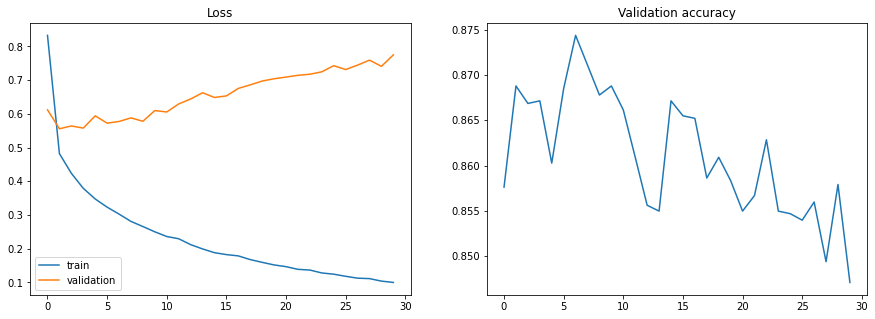

In [164]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [165]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [166]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 5 of 30 took 0.542s
	  training loss: 0.068825
	validation loss: 0.715789
	validation accuracy: 0.866
Epoch 10 of 30 took 0.662s
	  training loss: 0.040860
	validation loss: 0.900010
	validation accuracy: 0.867
Epoch 15 of 30 took 0.613s
	  training loss: 0.029514
	validation loss: 1.056068
	validation accuracy: 0.866
Epoch 20 of 30 took 0.584s
	  training loss: 0.008480
	validation loss: 1.118188
	validation accuracy: 0.875
Epoch 25 of 30 took 0.634s
	  training loss: 0.000186
	validation loss: 1.101482
	validation accuracy: 0.879
Epoch 30 of 30 took 0.566s
	  training loss: 0.000105
	validation loss: 1.123506
	validation accuracy: 0.880


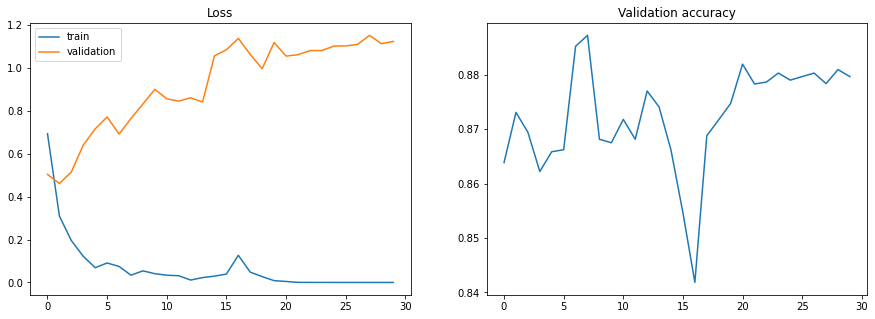

In [167]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

In [222]:
complex_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.RandomHorizontalFlip(p=0.5),
    #torchvision.transforms.RandomVerticalFlip(0.5),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomCrop(size=28),
    Flatten()
])

dataset = DatasetMNIST(
    './notMNIST_small',
    #'ABCD',
    transform=complex_transform
)

# shrink_inds = subset_ind(dataset, 1)
# dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 14979, labels: [0 1 2 3 4 5 6 7 8 9]


In [223]:
val_size = 0.25
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'training size:   {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

training size:   11235
validation size: 3744


In [224]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

iter_train = iter(train_loader)
exam_images, exam_labels = iter_train.next()
print(exam_images.shape, exam_labels.shape)

torch.Size([32, 784]) torch.Size([32])


### Dropout  and Batchnorm try

torch.Size([32, 784]) torch.Size([32])


In [228]:
Net = nn.Sequential(
    nn.Linear(784, 500),
    nn.BatchNorm1d(500),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(200, 10),
)
Net.to(device, torch.float32)

opt = torch.optim.Adam(Net.parameters(), lr=1e-3)

In [229]:
n_epochs = 10

train_loss, val_loss, val_accuracy = train_model(Net, 
                                                 train_loader, 
                                                 val_loader, 
                                                 loss_func, 
                                                 opt, 
                                                 n_epochs)

Epoch 5 of 10 took 18.291s
	  training loss: 0.349330
	validation loss: 0.299264
	validation accuracy: 0.906
Epoch 10 of 10 took 13.503s
	  training loss: 0.264136
	validation loss: 0.261668
	validation accuracy: 0.918


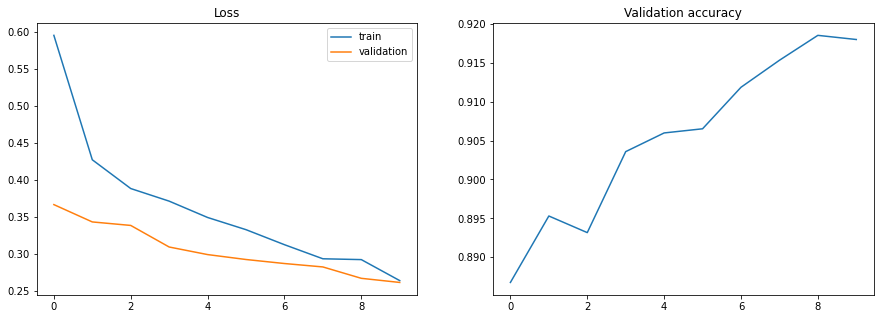

In [230]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [233]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [231]:
# create a brand new model
# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
# test()

In [253]:
Net_1 = nn.Sequential(
    nn.Linear(784, 500),
    nn.BatchNorm1d(500),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.Dropout(0.1),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.SGD(Net_1.parameters(), lr=0.001, momentum=0.9)

#### Define a training loop with model checkpointing

In [254]:
def train_save(epoch, save_interval, log_interval=100):
    
    train_loss = []
    val_loss = []
    val_accuracy = []
    

    
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()
        
        for batch_idx, (data, target) in enumerate(trainset_loader):
            
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = loss_func(output, target.type(torch.LongTensor))
            loss.backward()
            
            optimizer.step()
            ep_train_loss.append(loss.item())
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        
        model.eval() 
        with torch.no_grad():
            for X_batch, y_batch in valset_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # compute predictions
                ### YOUR CODE HERE
                
                predicts = model(X_batch)
                val_batch_loss = loss_func(predicts, y_batch.type(torch.LongTensor))
                ep_val_loss.append(val_batch_loss.item())
                y_pred = torch.argmax(predicts, dim = -1)### YOUR CODE HERE
                accuracy = (y_pred.cpu().numpy() == y_batch.cpu().numpy()).mean()
                ep_val_accuracy.append(accuracy) ### YOUR CODE HERE)

            # print the results for this epoch:
            if (ep+1)%5 == 0:

                print(f'Epoch {ep + 1} of {epoch} took {time.time() - start_time:.3f}s')

            train_loss.append(np.mean(ep_train_loss))
            val_loss.append(np.mean(ep_val_loss))
            val_accuracy.append(np.mean(ep_val_accuracy))
            if (ep+1)%5 == 0:
                print(f"\t  training loss: {train_loss[-1]:.6f}")
                print(f"\tvalidation loss: {val_loss[-1]:.6f}")
                print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
    
    return train_loss, val_loss, val_accuracy

In [255]:
trainset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valset_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loss, val_loss, val_accuracy  = train_save(epoch = 10, 
                                                 save_interval=500, 
                                                 log_interval=100)

Train Epoch: 0 [0/11235 (0%)]	Loss: 0.503506
Train Epoch: 0 [3200/11235 (28%)]	Loss: 0.172302
Train Epoch: 0 [6400/11235 (57%)]	Loss: 0.714332
Train Epoch: 0 [9600/11235 (85%)]	Loss: 0.434866
Train Epoch: 1 [1536/11235 (14%)]	Loss: 1.146913
Train Epoch: 1 [4736/11235 (42%)]	Loss: 0.971731
model saved to mnist-500.pth
Train Epoch: 1 [7936/11235 (70%)]	Loss: 0.766169
Train Epoch: 1 [11136/11235 (99%)]	Loss: 1.426817
Train Epoch: 2 [3072/11235 (27%)]	Loss: 0.905062
Train Epoch: 2 [6272/11235 (56%)]	Loss: 0.961563
Train Epoch: 2 [9472/11235 (84%)]	Loss: 0.298131
model saved to mnist-1000.pth
Train Epoch: 3 [1408/11235 (12%)]	Loss: 0.500204
Train Epoch: 3 [4608/11235 (41%)]	Loss: 0.000945
Train Epoch: 3 [7808/11235 (69%)]	Loss: 0.804761
Train Epoch: 3 [11008/11235 (98%)]	Loss: 1.823114
Train Epoch: 4 [2944/11235 (26%)]	Loss: 0.515177
model saved to mnist-1500.pth
Train Epoch: 4 [6144/11235 (55%)]	Loss: 0.656028
Train Epoch: 4 [9344/11235 (83%)]	Loss: 2.694373
Epoch 5 of 10 took 8.516s
	  tr

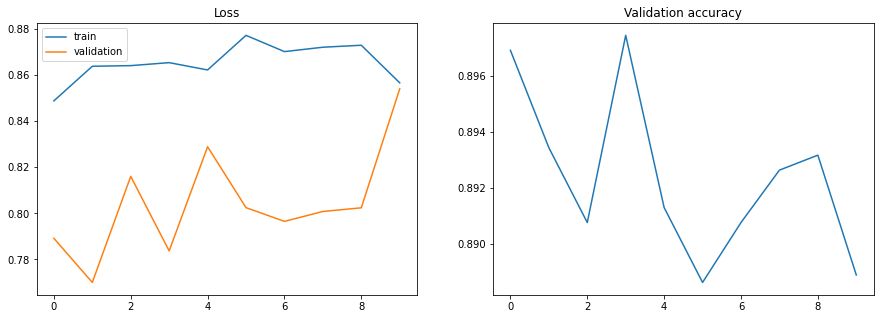

In [256]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)